# Chapter 21: Training Linear Classifiers with Logistic Regression

## 21.1 Linearly Separating Customers by Size

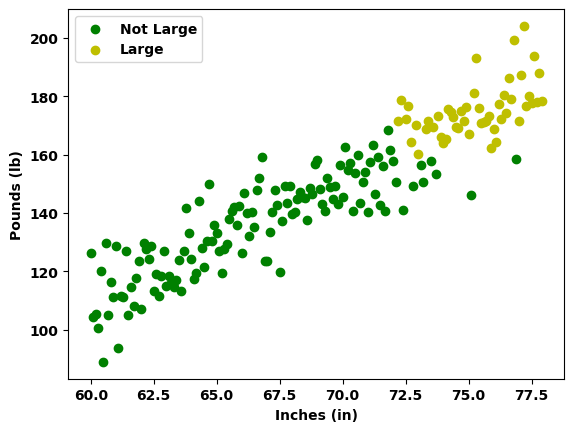

In [6]:
# Simulating categorized customer measurements
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)

# Plots customer measurements while coloring the customers based on class.
# Customer heights and weights are treated as two different features in the feature matrix X.
# Customer class type is stored with the label array y.
def plot_customers(X, y, xlabel='Inches (in)', ylabel='Pounds (lb)'):
    colors = ['g', 'y']
    labels = ['Not Large', 'Large']
    for i, (color, label) in enumerate(zip(colors, labels)):
        plt.scatter(X[:,0][y == i], X[:,1][y == i], color=color, label=label)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

inches = np.arange(60, 78, 0.1)
# Note: Scale is the STD
random_fluctuations = np.random.normal(scale=10, size=inches.size)
pounds = 4 * inches - 130 + random_fluctuations

# FOllows the linear formula to model weight as a function of height
X = np.array([inches, pounds]).T

# Customers are considered Large if their height is greater than 72 inches and their weight is greater than 160 lbs
# Makes an array of 0s and 1s to represent when a customer is considered 'Large' under the conditions above
y = ((X[:,0] > 72) & (X[:,1] > 160)).astype(int)

plot_customers(X, y)
plt.legend()
plt.show()

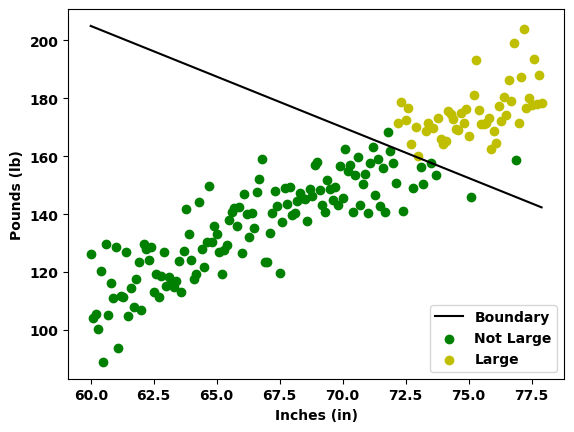

In [7]:
# Plotting a boundary to separate the two customer classes
def boundary(inches): return -3.5 * inches + 415
plt.plot(X[:,0], boundary(X[:,0]), color='k', label='Boundary')
plot_customers(X, y)
plt.legend()
plt.show()

The line above is a *linear decision boundary*  
**Linear Decision Boundary**: Can be used to accuratly destinguish between two classes

In [9]:
# Predicting classes using a linear boundary
from sklearn.metrics import f1_score
y_pred = []
for inches, lbs in X:
    # If b is a Python Boolean, int(b) returns 1 if the Boolean is True and 
    # 0 is the boolean is False. Hence, we can return the class label for 
    # measurements (inches, lbs) by running int(lbs > -3.5 * inches + 415)
    prediction = int(lbs > -3.5 * inches + 415)
    y_pred.append(prediction)

f_measure = f1_score(y_pred, y)
print(f'The f-measure is {f_measure:.2f}')

The f-measure is 0.97


A few notes on the inequality lbs > -3.5 * inches + lbs + 415
1. Inequality can become 3.5 * inches + lbs - 415 > 0  
2. Dot product of [x, y, z] @ [a, b, c] = x * a + y * b + z * c  
3. The dot product of [inches, lbs, 1] @ [3.1, 1, -415] = 3.5 * inches + lbs - 415  
4. Inequality now becomes w @ v > 0, with vectors w and v having the form of line 3  
  
Note: Only one of the w, v vectors os dependent on values of lbs and inches.  
The second vector, [3.5, 1, -415] does not vary with customer measurements. This is a *weight vector*  
**Weight Vector**: Invariant vector that is not dependent on input


In [10]:
# Predicting classes using vector dot products
weights = np.array([3.5, 1, -415])
predictions = [int(weights @ [inches, lbs, 1] > 0) for inches, lbs in X]
assert predictions == y_pred

**Padded Feature Matrix**: Making a new matrix, M, where each row is [inches, lbs, 1] rather than [inches, lbs] so we can just do the matrix-vector product M @ weights > 0, rather than creating a new vector, v, and runnning v @ weights > 0, recomputing v for every vector

In [11]:
# Predicting classes using matrix multiplication
M = np.column_stack([X, np.ones(X.shape[0])])
print("First five rows of our padded feature matrix are:")
print(np.round(M[:5], 2))

predictions = (M @ weights > 0)
assert predictions.tolist() == y_pred

First five rows of our padded feature matrix are:
[[ 60.   126.24   1.  ]
 [ 60.1  104.28   1.  ]
 [ 60.2  105.52   1.  ]
 [ 60.3  100.47   1.  ]
 [ 60.4  120.25   1.  ]]


**Linear Classifier**: Boiling down classification to a simple matrix-vector product. The only thing required is a weight vector

In [12]:
# Defining a linear classifier function
def linear_classifier(X, weights):
    M = np.column_stack([X, np.ones(X.shape[0])])
    return (M @ weights > 0).astype(int)

predictions = linear_classifier(X, weights)
assert predictions.tolist() == y_pred

**Bias**: The constant value stored in `weights[-1]`  
**Coefficients**: Remaining weights; During classification, each coefficient is multiplied against its corresponding feature

## 21.2 Training a Linear Classifier